In [1]:
import os
import shutil


def split_dataset(paths, orgin_dir, name):
    train_ratio = 0.6
    validation_ratio = 0.2
    test_ratio = 0.2
    size = len(paths)
    train_val_boundary = int(size * train_ratio)
    val_test_boundary = int(-1 * (size * test_ratio))
    train_dir = "dataset/Train"
    val_dir = "dataset/Validation"
    test_dir = "dataset/Test"
    os.makedirs(os.path.join(train_dir, name), exist_ok=True)
    os.makedirs(os.path.join(val_dir, name), exist_ok=True)
    os.makedirs(os.path.join(test_dir, name), exist_ok=True)
    for path in paths[:train_val_boundary]:
        shutil.copy(os.path.join(orgin_dir, path), os.path.join(train_dir, name))
    for path in paths[train_val_boundary:val_test_boundary]:
        shutil.copy(os.path.join(orgin_dir, path), os.path.join(val_dir, name))
    for path in paths[val_test_boundary:]:
        shutil.copy(os.path.join(orgin_dir, path), os.path.join(test_dir, name))


boot_paths = os.listdir("dataset/Shoe vs Sandal vs Boot Dataset/Boot")
shoe_paths = os.listdir("dataset/Shoe vs Sandal vs Boot Dataset/Shoe")
sandal_paths = os.listdir("dataset/Shoe vs Sandal vs Boot Dataset/Sandal")

split_dataset(boot_paths, "dataset/Shoe vs Sandal vs Boot Dataset/Boot", "Boot")
split_dataset(shoe_paths, "dataset/Shoe vs Sandal vs Boot Dataset/Shoe", "Shoe")
split_dataset(sandal_paths, "dataset/Shoe vs Sandal vs Boot Dataset/Sandal", "Sandal")


In [2]:
from keras import utils


SMALL_IMAGE_SIZE = (256, 256)


small_size_train_data = utils.image_dataset_from_directory(
    "dataset/Train",
    image_size=SMALL_IMAGE_SIZE,
    seed=1998,
)
small_size_val_data = utils.image_dataset_from_directory(
    "dataset/Validation",
    image_size=SMALL_IMAGE_SIZE,
    seed=1998,
)
small_size_test_data = utils.image_dataset_from_directory(
    "dataset/Test",
    image_size=SMALL_IMAGE_SIZE,
    seed=1998,
)
small_size_train_data.class_names


2022-10-28 14:00:38.160984: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-28 14:00:38.588111: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-28 14:00:39.725013: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-10-28 14:00:39.725104: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

Found 9000 files belonging to 3 classes.


2022-10-28 14:00:42.038758: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:42:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-10-28 14:00:42.081750: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:42:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-10-28 14:00:42.082150: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:42:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-10-28 14:00:42.085509: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate

Found 3000 files belonging to 3 classes.
Found 3000 files belonging to 3 classes.


['Boot', 'Sandal', 'Shoe']

In [3]:
import tensorflow as tf


def get_simple_model(image_size):
    model_in = tf.keras.layers.Input((*image_size, 3))
    # Data augmentation stage
    x = tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal")(model_in)
    x = tf.keras.layers.experimental.preprocessing.RandomRotation(0.05)(x)
    x = tf.keras.layers.experimental.preprocessing.RandomZoom(0.05)(x)
    # Extraction stage
    x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(x)
    x = tf.keras.layers.Conv2D(32, 3, padding="same", activation="relu")(x)
    x = tf.keras.layers.Conv2D(64, 3, strides=2, padding="same", activation="relu")(x)
    x = tf.keras.layers.Conv2D(64, 3, padding="same", activation="relu")(x)
    x = tf.keras.layers.Conv2D(128, 3, strides=2, padding="same", activation="relu")(x)
    x = tf.keras.layers.Conv2D(256, 3, strides=2, padding="same", activation="relu")(x)
    # Classification stage
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(2048 ,activation="relu", kernel_regularizer="l2")(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    model_out = tf.keras.layers.Dense(3, activation="softmax")(
        x
    )
    # Return model
    return tf.keras.Model(inputs=[model_in], outputs=[model_out])


simple_model = get_simple_model(SMALL_IMAGE_SIZE)
simple_model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 random_flip (RandomFlip)    (None, 256, 256, 3)       0         
                                                                 
 random_rotation (RandomRota  (None, 256, 256, 3)      0         
 tion)                                                           
                                                                 
 random_zoom (RandomZoom)    (None, 256, 256, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 32)      896       
                                                             

In [4]:
import numpy as np


class CustomSparseMAE(tf.keras.metrics.Metric):
    def __init__(self, name="custom_mae", **kwargs):
        super().__init__(name, dtype=None, **kwargs)
        self.data_len = self.add_weight("data_len", initializer="zero")
        self.mae = self.add_weight("mae", initializer="zero")

    def update_state(self, y_true, y_pred, sample_weight=None):
        batch_size = tf.shape(y_pred)[0]
        num_classes = tf.shape(y_pred)[-1]
        batch_data_len = tf.cast(batch_size * num_classes, tf.float32)
        self.data_len.assign_add(batch_data_len)

        one_hot_y_true = tf.one_hot(y_true, num_classes)
        reshaped_y_pred = tf.reshape(y_pred, (-1, 1, num_classes))
        batch_mae = tf.reduce_sum(
            tf.abs(tf.cast(one_hot_y_true, tf.float32) - tf.cast(y_pred, tf.float32)),
        )
        self.mae.assign_add(batch_mae)

    def result(self):
        return self.mae / self.data_len


In [5]:
simple_model.compile(
    optimizer=tf.keras.optimizers.RMSprop(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy(), CustomSparseMAE()],
)


In [6]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_sparse_categorical_accuracy", patience=5, restore_best_weights=True,
)


In [7]:
simple_model_history = simple_model.fit(
    small_size_train_data,
    batch_size=32,
    epochs=100,
    validation_data=small_size_val_data,
    callbacks=[early_stopping],
)


Epoch 1/100


2022-10-28 14:00:50.308484: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8101
2022-10-28 14:00:51.351727: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


282/282 [==============================] - 157s 529ms/step - loss: 3.5765 - sparse_categorical_accuracy: 0.5461 - custom_mae: 14.1713 - val_loss: 2.2170 - val_sparse_categorical_accuracy: 0.7007 - val_custom_mae: 14.0998
Epoch 2/100
282/282 [==============================] - 147s 521ms/step - loss: 2.1980 - sparse_categorical_accuracy: 0.7194 - custom_mae: 14.0921 - val_loss: 2.3712 - val_sparse_categorical_accuracy: 0.7183 - val_custom_mae: 13.9769
Epoch 3/100
282/282 [==============================] - 147s 521ms/step - loss: 2.0691 - sparse_categorical_accuracy: 0.8113 - custom_mae: 13.9277 - val_loss: 2.1419 - val_sparse_categorical_accuracy: 0.8187 - val_custom_mae: 13.9141
Epoch 4/100
282/282 [==============================] - 142s 504ms/step - loss: 2.0452 - sparse_categorical_accuracy: 0.8429 - custom_mae: 13.8951 - val_loss: 1.8950 - val_sparse_categorical_accuracy: 0.8970 - val_custom_mae: 13.8338
Epoch 5/100
282/282 [==============================] - 141s 501ms/step - loss: 1

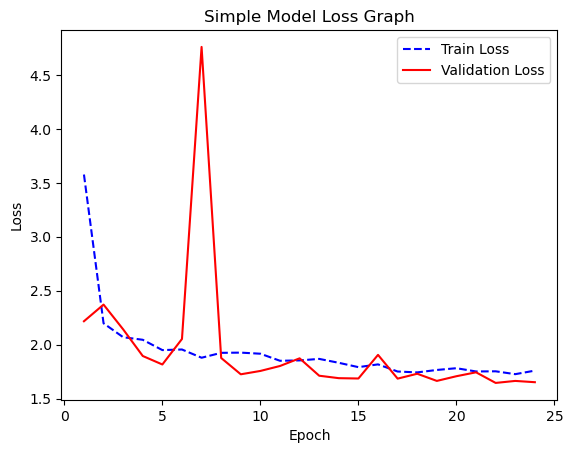

In [8]:
import matplotlib.pyplot as plt
epoch_range = range(1, len(simple_model_history.history["loss"]) + 1)
plt.plot(epoch_range, simple_model_history.history["loss"], "b--", label="Train Loss")
plt.plot(epoch_range, simple_model_history.history["val_loss"], "r", label="Validation Loss")
plt.title("Simple Model Loss Graph")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

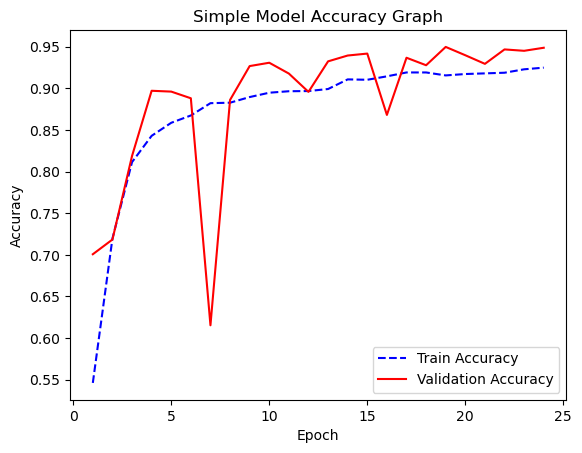

In [9]:
import matplotlib.pyplot as plt
epoch_range = range(1, len(simple_model_history.history["sparse_categorical_accuracy"]) + 1)
plt.plot(epoch_range, simple_model_history.history["sparse_categorical_accuracy"], "b--", label="Train Accuracy")
plt.plot(epoch_range, simple_model_history.history["val_sparse_categorical_accuracy"], "r", label="Validation Accuracy")
plt.title("Simple Model Accuracy Graph")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

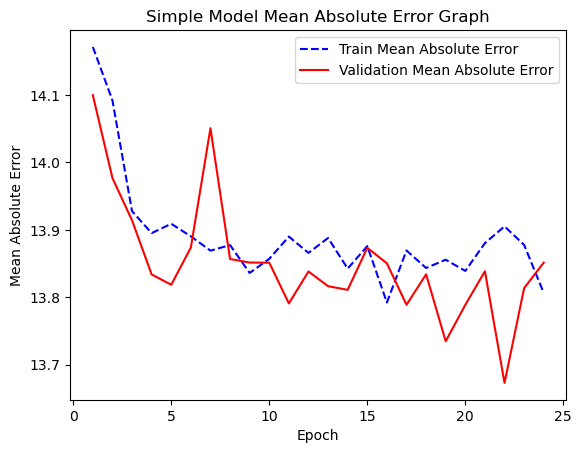

In [10]:
import matplotlib.pyplot as plt
epoch_range = range(1, len(simple_model_history.history["custom_mae"]) + 1)
plt.plot(epoch_range, simple_model_history.history["custom_mae"], "b--", label="Train Mean Absolute Error")
plt.plot(epoch_range, simple_model_history.history["val_custom_mae"], "r", label="Validation Mean Absolute Error")
plt.title("Simple Model Mean Absolute Error Graph")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Mean Absolute Error")
plt.show()

In [11]:
test_scores = simple_model.evaluate(small_size_test_data, return_dict=True)
test_scores

94/94 [==============================] - 8s 83ms/step - loss: 1.6603 - sparse_categorical_accuracy: 0.9473 - custom_mae: 13.8823


{'loss': 1.6602680683135986,
 'sparse_categorical_accuracy': 0.9473333358764648,
 'custom_mae': 13.882286071777344}